In [1]:
set.seed(1234)

library("here")
library(devtools)
library(Seurat)
library(harmony)
library(RcppML)

devtools::load_all('/home/jpm73279/Socrates')
data_path <- "/scratch/jpm73279/comparative_single_cell/02.QC_clustering/oryza_sativa/QC_output/"

here() starts at /home/jpm73279/Mendieta_et_al_comparative_single_cell

Loading required package: usethis

Attaching SeuratObject

Loading required package: Rcpp

i Loading Socrates
Loading required package: cicero

Loading required package: monocle

Loading required package: Matrix

Loading required package: Biobase

Loading required package: BiocGenerics


Attaching package: 'BiocGenerics'


The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


The following objects are masked from 'package:base':

    Filter, Find, Map, Position, Reduce, anyDuplicated, append,
    as.data.frame, basename, cbind, colnames, dirname, do.call,
    duplicated, eval, evalq, get, grep, grepl, intersect, is.unsorted,
    lapply, mapply, match, mget, order, paste, pmax, pmax.int, pmin,
    pmin.int, rank, rbind, rownames, sapply, setdiff, sort, table,
    tapply, union, unique, unsplit, which.max, which.min


Welcome to Bioconductor

    Vignettes contain introductory materia

In [2]:
rep_1 <- paste0(data_path,"Oryza_sativa.scATAC_rep1_QC_soc_obj.rds")
rep_2 <- paste0(data_path,"Oryza_sativa.scATAC_rep2_QC_soc_obj.rds")
prefix <- "Os_leaf.merged_replicates"
#PDF_dir <- "PDF_outputs"
#dir.create(PDF_dir)

rep_1_read <- readRDS(rep_1)
rep_2_read <- readRDS(rep_2)
rep_files <- list(rep_1_read, rep_2_read)
names(rep_files) <- c("rep1", "rep2")


print("Merging Object")
merged.obj <- mergeSocratesRDS(obj.list=rep_files)


print("Generating Socrates Obj")
    ## Generate Socrates Object
soc.obj <- merged.obj




[1] "Merging Object"
[1] "Generating Socrates Obj"


In [12]:

library(tidyverse)
#6/21/2023
## Annotate Current meta
## https://github.com/Jome0169/Mendieta_et_al_comparative_single_cell/issues/49#issuecomment-1601055314
os.current_meta <- read.table("/scratch/jpm73279/comparative_single_cell/02.QC_clustering/oryza_sativa/clustering/Os_leaf.merged_replicates.SVD.full.metadata.txt")
os.current_meta_v1_annot <- os.current_meta %>% 
    mutate_at("LouvainClusters", factor) %>% 
     mutate(V1_annotation = case_when(LouvainClusters == 1 ~ "remove",
                                  LouvainClusters == 2 ~ "mesophyll",
                                  LouvainClusters == 3 ~ "companion cells ",
                                  LouvainClusters == 4 ~ "epidermis",
                                  LouvainClusters == 5 ~ "mesophyll",
                                  LouvainClusters == 6 ~ "bundle_sheath",
                                  LouvainClusters == 7 ~ "epidermis",
                                  LouvainClusters == 8 ~ "remove",
                                  LouvainClusters == 9 ~ "remove",
                                  LouvainClusters == 10 ~ "unknown ",
                                  LouvainClusters == 11 ~ "remove",
                                  LouvainClusters == 12 ~ "unknown")) %>% 
    dplyr::filter(V1_annotation != "remove")
                                  

In [25]:
barcode_array <- os.current_meta_v1_annot$cellID
copied_counts <- soc.obj$counts
filter_indices <- which(colnames(copied_counts) %in% barcode_array)
# Subset the matrix using these indices
filtered_mat <- copied_counts[, filter_indices]


soc.obj$meta <- os.current_meta_v1_annot
soc.obj$counts <- filtered_mat

In [26]:
    print("Generating Graphs")
    # estimate log10 number of accessible regions per cell
    cell.counts <- Matrix::colSums(soc.obj$counts)

    # estimate peak accessibility frequency across cells
    site.freq <- Matrix::rowMeans(soc.obj$counts)

[1] "Generating Graphs"


Warning message in xy.coords(x, y, xlabel, ylabel, log):
"16 x values <= 0 omitted from logarithmic plot"
Warning message in xy.coords(x, y, xlabel, ylabel, log):
"2 x values <= 0 omitted from logarithmic plot"


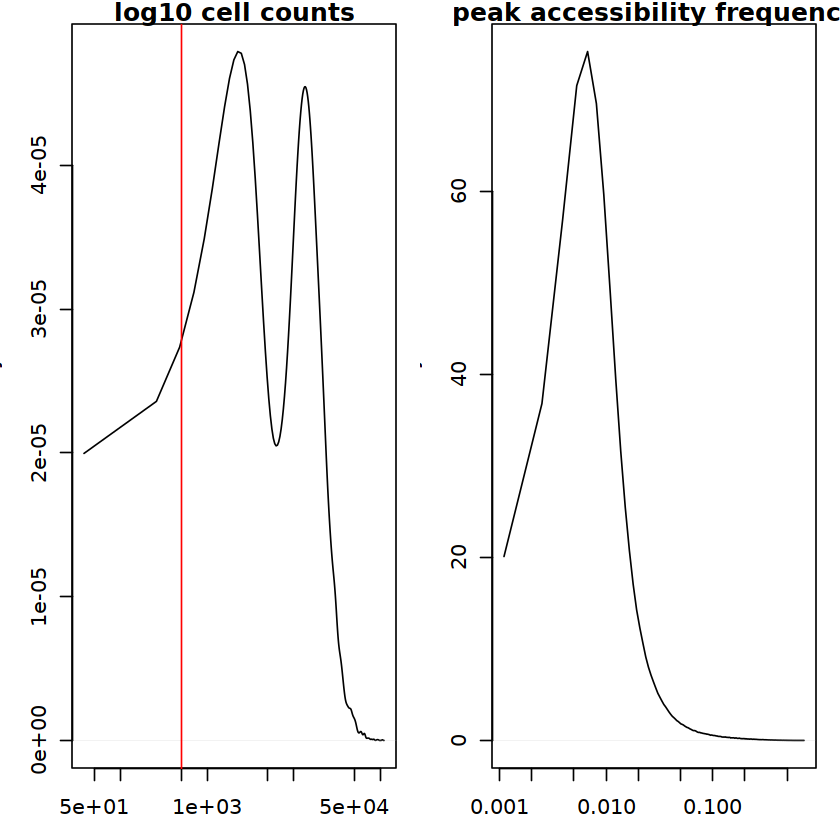

In [27]:
layout(matrix(c(1:2), ncol=2))
par(mar=c(3,3,1,1))
plot(density(cell.counts), main="log10 cell counts", log="x")
abline(v=500, col="red")
plot(density(site.freq), main="peak accessibility frequency", log="x")

In [17]:
site.freq <- Matrix::rowMeans(soc.obj$counts)

In [31]:
# get per cell feature counts --------------------------------------------
cell.counts <- Matrix::colSums(soc.obj$counts)  # count number of features with Tn5 insertions per cell
cell.counts.z <- as.numeric(scale(cell.counts)) # convert features counts into Z-scores
cell.counts.threshold <- max(c(cell.counts[cell.counts.z < -1], 100)) # minimum feature counts (greater of 1 std or 1000)


# clean sparse counts matrix ---------------------------------------------
soc.obj <- cleanData(soc.obj, 
                     min.c=100,  # minimum number of accessible features per cell
                     min.t=0.02,  # minimum feature frequency across cells
                     max.t=0.15, # maximum feature frequency across cells
                     verbose=T)

   * Input: cells = 6108 | peaks = 654529

   * Filtered: cells = 6108 | peaks = 126723



In [32]:
# normalize with TFIDF ---------------------------------------------------
soc.obj <- tfidf(soc.obj)

In [33]:
# project with NMF -------------------------------------------------------
soc.obj.reduce_dim <- reduceDims(soc.obj,
                      method="SVD", 
                      cor.max=.7,
                      n.pcs=30, 
                      svd_slotName="SVD")


# reduce to 2-dimensions with UMAP ---------------------------------------
soc.obj.project_umap <- projectUMAP(soc.obj.reduce_dim, 
                       verbose=T,
                       k.near=35,
                       m.dist=0.01,
                       svd_slotName="SVD")

 - non-linear dimensionality reduction with UMAP ...

11:48:07 UMAP embedding parameters a = 1.896 b = 0.8006

11:48:07 Read 6108 rows and found 30 numeric columns

11:48:07 Using Annoy for neighbor search, n_neighbors = 25

11:48:07 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

11:48:08 Writing NN index file to temp file /tmp/RtmpPCHa0r/fileb6b0558fad97

11:48:08 Searching Annoy index using 16 threads, search_k = 2500

11:48:08 Annoy recall = 100%

11:48:31 Commencing smooth kNN distance calibration using 16 threads
 with target n_neighbors = 25

11:48:35 Initializing from normalized Laplacian + noise (using irlba)

11:48:35 Commencing optimization for 500 epochs, with 255784 positive edges

11:49:02 Optimization finished



 - filtering outliers in UMAP manifold (z-score e.thresh = 3) ...

 - creating seurat object for graph-based clustering ...

Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"
Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 6024
Number of edges: 528459

Running Louvain algorithm...
Maximum modularity in 100 random starts: 0.5798
Number of communities: 17
Elapsed time: 18 seconds


 - finished graph-based clustering ...

   * removing low quality clusters ...

   * filtering per-cluster outliers (z-score filtDistClst2 = 5) ...

   * total number of cells surviving subcluster filtering = 5951

 - filtering clusters with low cell/read counts ...



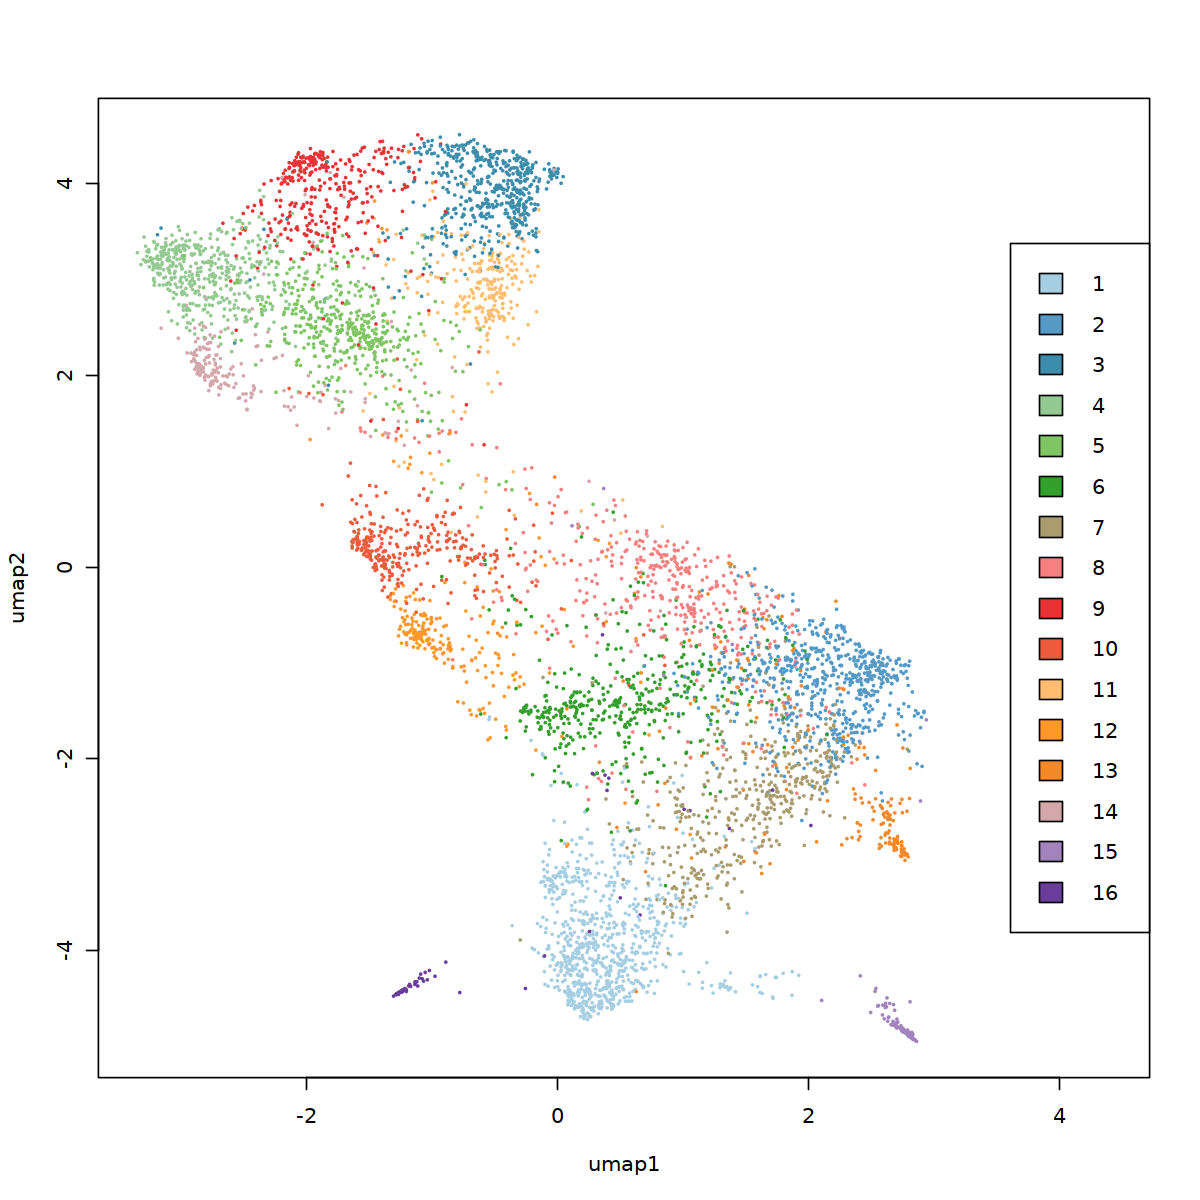

In [90]:
# identify clusters using neighborhood graph -----------------------------
soc.obj.project_umap <- callClusters(soc.obj.project_umap, 
                        res=2,
                        verbose=T,
                        svd_slotName= "SVD",
                        cleanCluster=T)

#plot cluster membership on UMAP embedding ------------------------------
options(repr.plot.width=10, repr.plot.height=10)
# NMF
#pdf(paste0(out,".NMF.full.UMAP.clusters.pdf"), width=10, height=10)
plotUMAP(soc.obj.project_umap, cex=0.3)
#dev.off()



In [91]:
options(repr.plot.width=20, repr.plot.height=10)
cluster_plot <- as_tibble(soc.obj.project_umap$Clusters)

read_depth_umap <- ggplot(cluster_plot ,aes(umap1, umap2, color = log(total))) + 
    geom_jitter(size = .1) + facet_grid(.~sampleID) +     scale_color_viridis_c()

In [92]:
library(cowplot)
umap_cluster_colors <- c("#DEA940","#A2A763","#D6EEBE","#5894D4","#6AAD51","#6C8686","#FFD92F", "#7f2201","#b53310",
                         "#E7673B","#FB9A99","#E31A1C","#FDBF6F","#CAB2D6","#386CB0","#FFFFB3", "#5dead5","#c11577",
                         "#CCCCCC", "#7570B3","#B15928", "#6A3D9A", "#d87c6a", "#0060e8", "#84c5ff", "#ffd460", "#d81397")


col_scale <- scale_colour_manual(name = "grp", values = umap_cluster_colors)


colored_umap <- ggplot(cluster_plot ,aes(umap1, umap2, color = LouvainClusters)) + 
    col_scale + 
    geom_jitter(size = .1) + facet_grid(.~sampleID) + theme_half_open() +
    guides(colour = guide_legend(override.aes = list(size=5))) +
    geom_point(size = .25, alpha = .8)


V1_annotation <- ggplot(cluster_plot ,aes(umap1, umap2, color = V1_annotation)) + 
    col_scale + 
    geom_jitter(size = .1) + facet_grid(.~sampleID) + theme_half_open() +
    guides(colour = guide_legend(override.aes = list(size=5))) +
    geom_point(size = .25, alpha = .8)

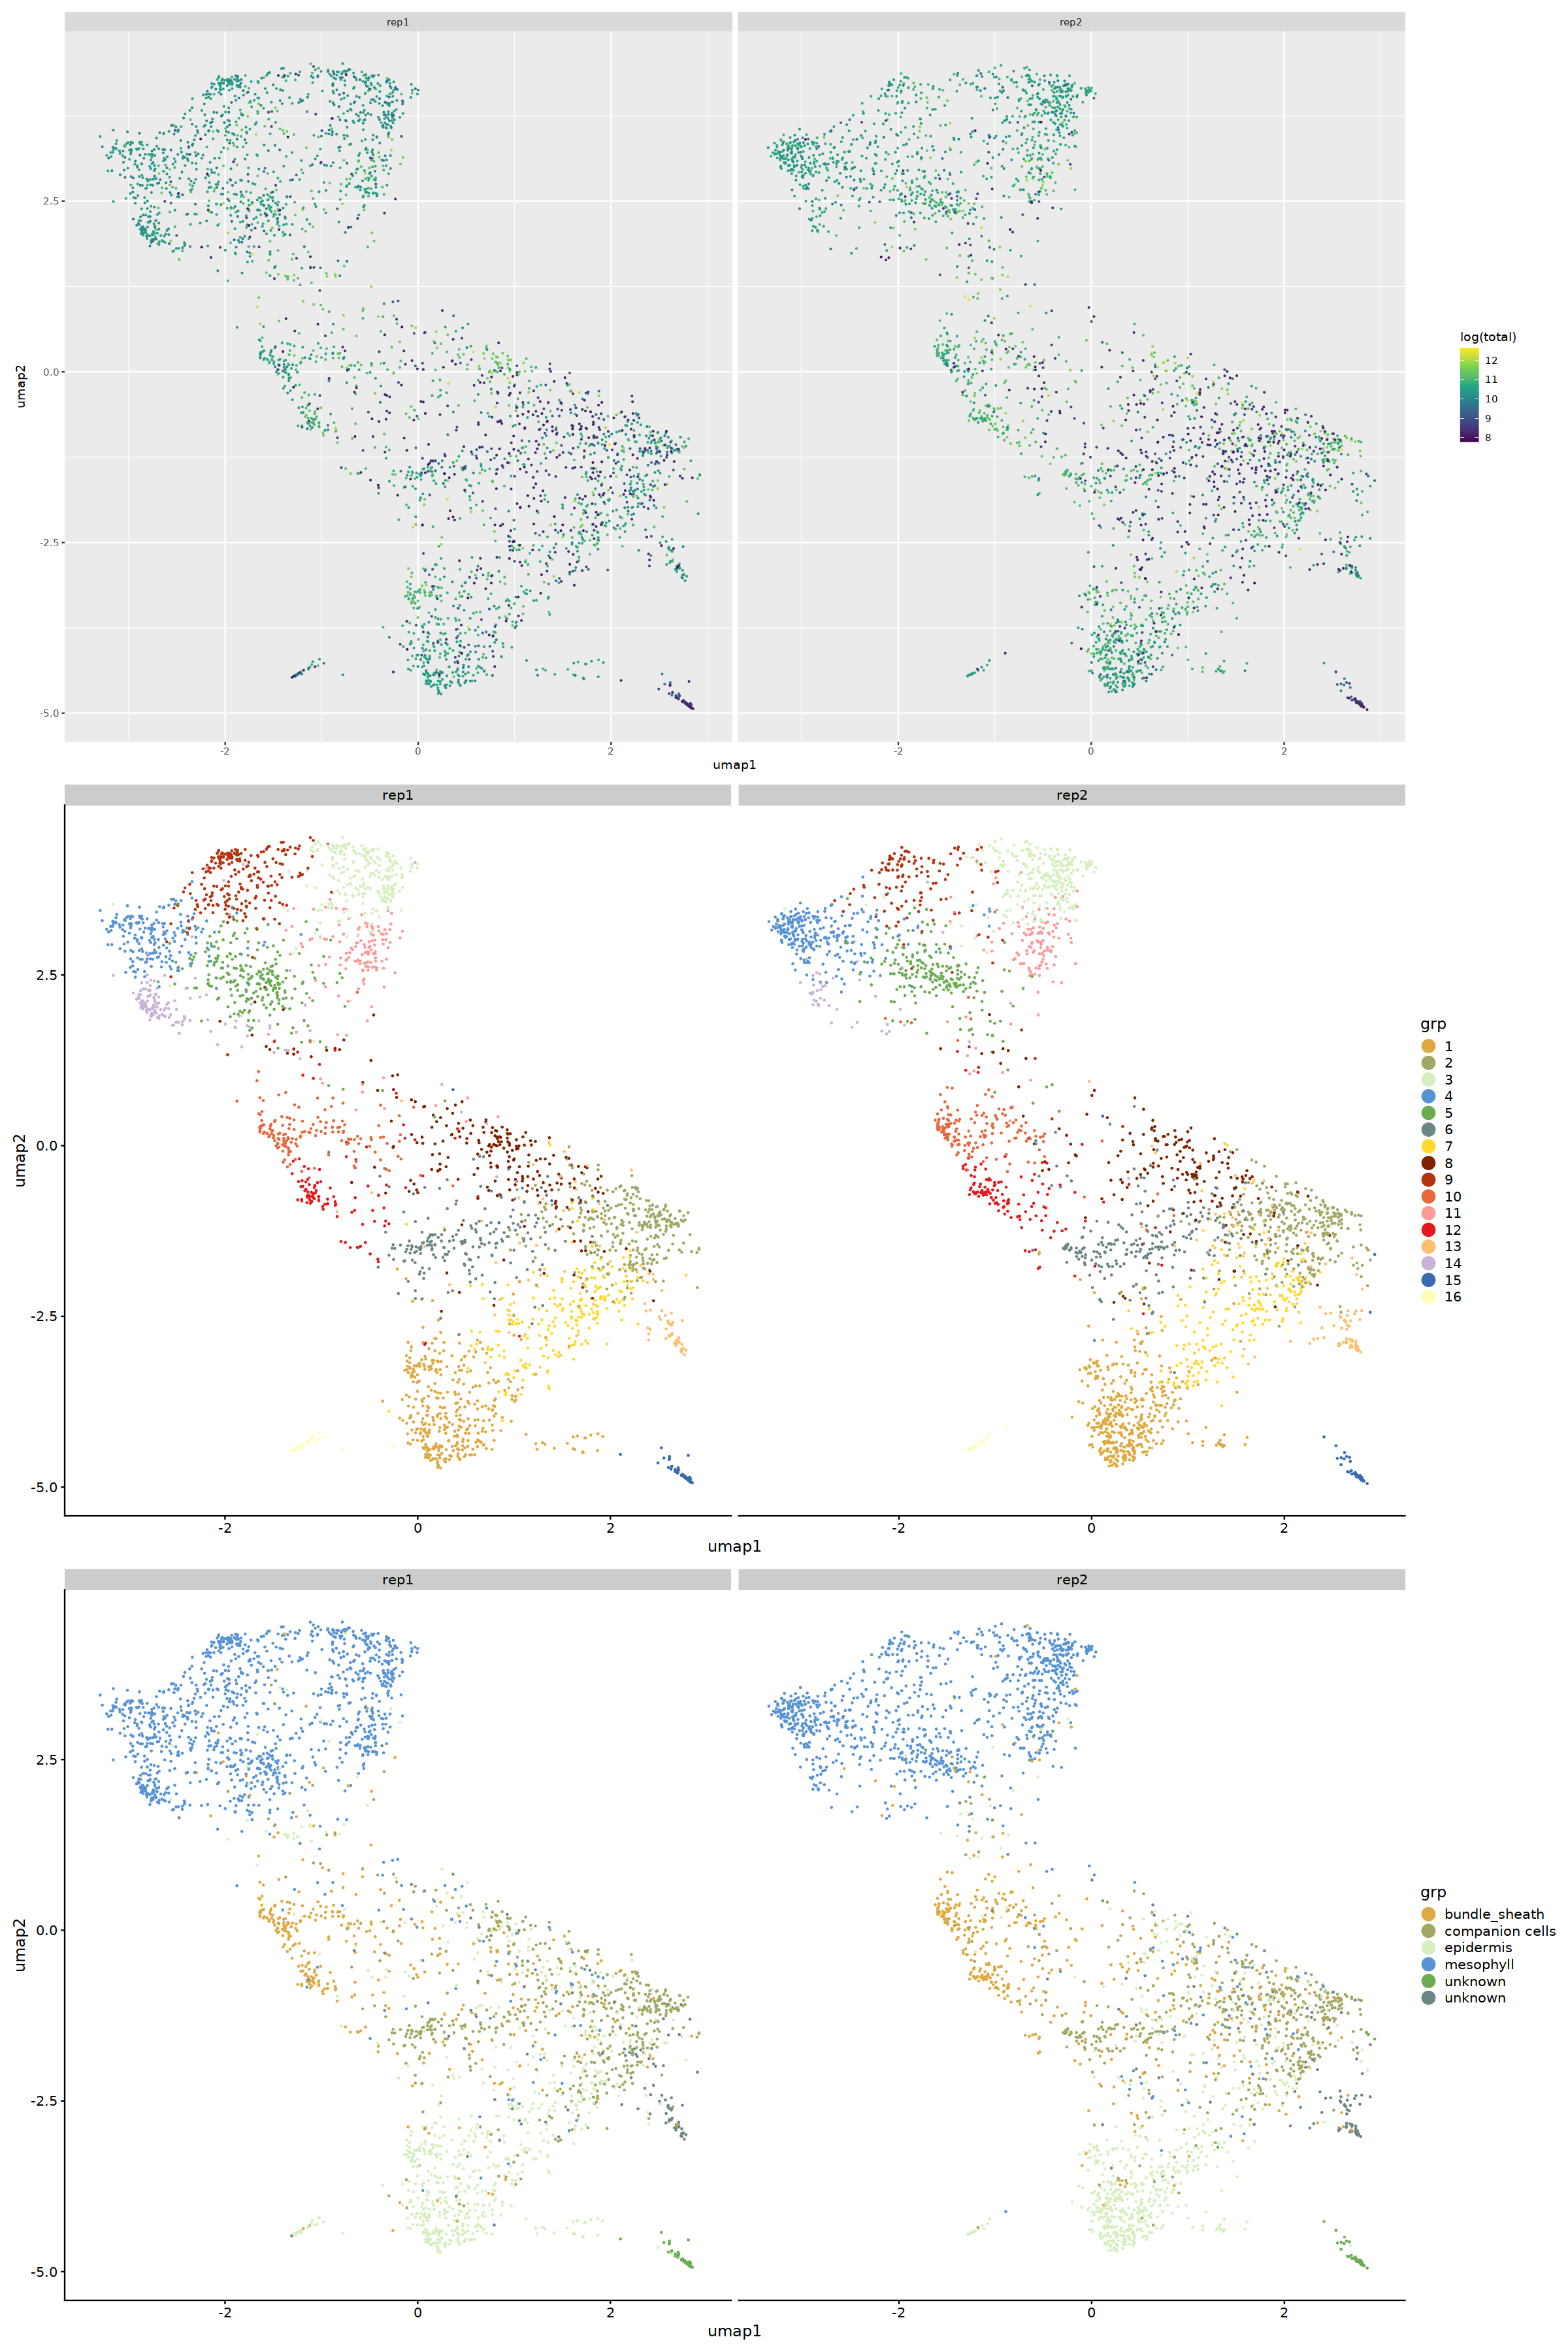

In [93]:

options(repr.plot.width=20, repr.plot.height=30)
read_depth_umap / colored_umap/V1_annotation

In [117]:
clusters_no_spaces <- soc.obj.project_umap$Clusters %>% 
  mutate(V1_annotation = str_replace_all(V1_annotation, " ", "_"))

In [118]:
prefix <- "Os_leaf.merged_replicates.reclustered"
output_location <- "/scratch/jpm73279/comparative_single_cell/02.QC_clustering/oryza_sativa/clustering/"
#paste0(data_path, prefix,".merged_clusters.sparse")
# output text files
#nmf.meta <- soc.obj.project_umap$Clusters
nmf.rd <- soc.obj.project_umap$SVD

write.table(clusters_no_spaces, file=paste0(output_location,prefix, ".SVD.full.metadata.txt"), quote=F, row.names=T, col.names=T, sep="\t")
write.table(nmf.rd, file=paste0(output_location, prefix, ".SVD.full.reduced_dimensions.txt"), quote=F, row.names=T, col.names=T, sep="\t")

In [119]:
### Generate Sparse Matrix-
trip <- as.data.frame(summary(soc.obj.project_umap$counts))
trip$i <- rownames(soc.obj.project_umap$counts)[trip$i]
trip$j <- colnames(soc.obj.project_umap$counts)[trip$j]

write.table(trip, file=paste0(output_location, prefix, ".SVD.sparse"), quote=F, row.names=T, col.names=T, sep="\t")

In [54]:
library("presto")
run_presto <- function(meta_obj, 
                       meta_slot = "Clusters", 
                       cluster_name = "LouvainClusters", 
                       counts_raw="acr_counts_raw"){
    ### Pull the correct meta datafrom the Socrates Object
    sparse_matrix <- meta_obj[[counts_raw]]
    meta_data <- meta_obj[[meta_slot]]
    
    print(head(as_tibble(meta_data)))
        
    ### Read the Giant Sparse Matrix
    loaded_sparse_matric <- read_delim(sparse_matrix, delim='\t', 
                                       col_names = c("gene_name", "barcode", "accessability"), 
                                       col_types = "ccn")
    
    print(head(loaded_sparse_matric))
    combined_large_w_sparse <- loaded_sparse_matric  %>% 
        filter(gene_name != "Annotation")  %>% 
        dplyr::select(gene_name, barcode, accessability)  %>% 
        left_join(., meta_data, by = c("barcode" = "cellID"))  %>% 
        filter(is.na(!!sym(cluster_name)) != TRUE)  %>% 
        arrange(!!sym(cluster_name))
    
    #order <- combined_large_w_sparse[!!sym(cluster_name)]

    combined_large_w_sparse <- combined_large_w_sparse  %>% 
        dplyr::select(gene_name, barcode, accessability)  %>% 
        mutate(across(accessability, as.numeric))
    
    
    gene_names <- unique(combined_large_w_sparse$gene_name)
    barcodes <- unique(combined_large_w_sparse$barcode)

    combined_large_w_sparse$row <- match(combined_large_w_sparse$gene_name, gene_names)
    combined_large_w_sparse$col <- match(combined_large_w_sparse$barcode, barcodes)


    UIMatrix <- sparseMatrix(i = combined_large_w_sparse$row,
                         j = combined_large_w_sparse$col,
                         x = combined_large_w_sparse$accessability,
                         dimnames=list(gene_names, barcodes))

    print(head(tibble(barcode = unlist(UIMatrix@Dimnames[2]))))
    barcode_tibble <- tibble(barcode = unlist(UIMatrix@Dimnames[2])) %>% 
        left_join(., as_tibble(meta_data), by = c("barcode" = "cellID"))  %>% 
        filter(is.na(total) != TRUE)
    
    print(dim(barcode_tibble))
    print(dim(UIMatrix))
    
    clust_name <- c(cluster_name)
    garbbed_louv_order <- pull(barcode_tibble,!!sym(clust_name))

    sparse_matrix_test <- wilcoxauc(UIMatrix, garbbed_louv_order)
    
    meta_obj[["presto_marker"]] <- sparse_matrix_test
    
    return(meta_obj)
}

In [55]:
library("here")
library(devtools)
library(Seurat)

load_all('/home/jpm73279/Socrates')



# bed <- system.file("extdata", "test.tn5.bed.gz", package = "Socrates")
#ann <- system.file("extdata", "gencode.v19.annotation.gff3.gz", package = "Socrates")
#chr <- system.file("extdata", "hg19.txt", package = "Socrates")
reference_genome_path <- "/home/jpm73279/genome_downloads/Osativa/v7.0/"
#analysis_path <- "/scratch/jpm73279/comparative_single_cell/01.alignments_annotations/Orzchloa_fusca/"
analysis_path <- "/scratch/jpm73279/comparative_single_cell/01.alignments_annotations/oryza_sativa/"


ann <- paste0(reference_genome_path,"annotation/Osativa_323_v7.0.gene.gff3")
chr <- paste0(reference_genome_path,"assembly/Osativa_323_v7.0.chrom.sizes")
Oryza_sat <- "/scratch/jpm73279/comparative_single_cell/01.alignments_annotations/oryza_sativa/Os.combined_reps.sorted.bed"

#Load Object
Os.leaf <- loadBEDandGenomeData(Oryza_sat, ann, chr)


i Loading Socrates
Warning message:
"replacing previous import 'scales::viridis_pal' by 'viridis::viridis_pal' when loading 'Socrates'"
Running pre-check on input files and executable paths ...

BED file path = /scratch/jpm73279/comparative_single_cell/01.alignments_annotations/oryza_sativa/Os.combined_reps.sorted.bed ... ok

GFF file path = /home/jpm73279/genome_downloads/Osativa/v7.0/annotation/Osativa_323_v7.0.gene.gff3 ... ok

Chromosome sizes file path = /home/jpm73279/genome_downloads/Osativa/v7.0/assembly/Osativa_323_v7.0.chrom.sizes ... ok

Macs2 is installed .... ok

 - loading data (this may take obj while for big BED files) ...

 - finished loading data



In [96]:
library(tidyverse)
#os_meta_data <- copied_merged_values_updated_clusteing.cleaned.reduce_dims$meta #<- read_delim("/scratch/jpm73279/comparative_single_cell/02.QC_clustering/oryza_sativa/clustering/Os_leaf.merged_replicates.SVD.full.metadata.txt", skip = 1,
#                           #col_names =  c("row_n",'cellID', 'total', 'tss', 'acrs', 'ptmt', 'nSites', 'log10nSites', 'pTSS', 'FRiP', 'pOrg', 'tss_z', 'acr_z', 'sites_z', 'qc_check', 'background', 'cellbulk', 'is_cell', 'sampleID', 'umap1', 'umap2', 'doubletscore', 'd.type', 'LouvainClusters'))
os_gene_counts <- "/scratch/jpm73279/comparative_single_cell/04.marker_annotation/oryza_sativa/acc_metrics_leaf_clusering/oryza_sativa.gene_body_acc_leaf_clusering.counts.txt" 

Os.leaf$meta <- soc.obj.project_umap$Clusters
Os.leaf$acr_counts_raw <- os_gene_counts

In [97]:
Os.leaf$row_n <- Os.leaf$cellID

In [98]:
glimpse(Os.leaf)

List of 8
 $ bed           :'data.frame':	566225349 obs. of  5 variables:
  ..$ V1: chr [1:566225349] "Chr1" "Chr1" "Chr1" "Chr1" ...
  ..$ V2: int [1:566225349] 502 581 602 636 1004 1005 1005 1005 1005 1005 ...
  ..$ V3: int [1:566225349] 503 582 603 637 1005 1006 1006 1006 1006 1006 ...
  ..$ V4: chr [1:566225349] "CB:Z:CCCTCTCCACCTGGTG-1-Os.leaf1" "CB:Z:GTTATGGCATTGTTCT-1-Os.leaf1" "CB:Z:CCCTCTCCACCTGGTG-1-Os.leaf1" "CB:Z:GTTATGGCATTGTTCT-1-Os.leaf1" ...
  ..$ V5: chr [1:566225349] "+" "+" "-" "-" ...
 $ gff           :Reference class 'TxDb' [package "GenomicFeatures"] with 6 fields
  ..$ conn           :Formal class 'SQLiteConnection' [package "RSQLite"] with 8 slots
  ..$ packageName    : chr(0) 
  ..$ user2seqlevels0: int [1:14] 1 2 3 4 5 6 7 8 9 10 ...
  ..$ user_seqlevels : chr [1:14] "Chr1" "Chr10" "Chr11" "Chr12" ...
  ..$ user_genome    : chr [1:14] NA NA NA NA ...
  ..$ isActiveSeq    : logi [1:14] TRUE TRUE TRUE TRUE TRUE TRUE ...
  ..and 16 methods, of which 2 are  possib

In [99]:
library(presto)
Os.leaf.presto <- run_presto(Os.leaf,
           meta_slot = "meta",
           counts_raw = "acr_counts_raw",
           cluster_name = "LouvainClusters")

# A tibble: 6 x 24
  cellID        total    tss   acrs  ptmt nSites log10nSites  pTSS  FRiP    pOrg
  <chr>         <int>  <int>  <int> <int>  <int>       <dbl> <dbl> <dbl>   <dbl>
1 CB:Z:CTTGCT~ 299976 106766 120877  2500 105019        5.02 0.356 0.403 0.00833
2 CB:Z:CCGTGA~ 261285 102590 131306  2813  83707        4.92 0.393 0.503 0.0108 
3 CB:Z:CCCTAA~ 223899  84024 102085  1747  78890        4.90 0.375 0.456 0.00780
4 CB:Z:TTACTT~ 191972  70130  69111  1907  74294        4.87 0.365 0.360 0.00993
5 CB:Z:GTCGTA~ 182684  65937  66737  2674  71114        4.85 0.361 0.365 0.0146 
6 CB:Z:GGGTGT~ 190610  69248  77421  1065  70155        4.85 0.363 0.406 0.00559
# i 14 more variables: tss_z <dbl>, acr_z <dbl>, sites_z <dbl>, qc_check <int>,
#   background <dbl>, cellbulk <dbl>, is_cell <int>, sampleID <chr>,
#   umap1 <dbl>, umap2 <dbl>, doubletscore <dbl>, d.type <chr>,
#   LouvainClusters <fct>, V1_annotation <chr>
# A tibble: 6 x 3
  gene_name      barcode                          acces

In [100]:
marker_list_pm_file <- "/home/jpm73279/genome_downloads/Osativa/v7.0/Rice_markers/Os.markers_from_zm.markers.specified.bed"
marker_list_pm <- read_delim(marker_list_pm_file, delim='\t', 
                                       col_names = c("chr", "start", "stop", "geneID", "gene_name", "cell_type", "tissue"))

Rows: 165 Columns: 7
-- Column specification --------------------------------------------------------
Delimiter: "\t"
chr (5): chr, geneID, gene_name, cell_type, tissue
dbl (2): start, stop

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [101]:
head(marker_list_pm)

chr,start,stop,geneID,gene_name,cell_type,tissue
<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
Chr12,17302072,17305326,LOC_Os12g29220,Zm_sweet13a__sweet13b__sweet13c,abaxial_bundle_sheath.phloem_parenchyma,leaf
Chr8,20528291,20535292,LOC_Os08g33050,Zm_kan1,abaxial_domains,leaf;tassel;ear;axillaryBud
Chr6,1962245,1963580,LOC_Os06g04540,Zm_BAF1,axillary_meristem,axillaryBud;leaf;tassel;ear
Chr1,41741159,41744666,LOC_Os01g72020,Zm_tru1,"axillary_meristem_lateral_primordia,basal_comparment_lateral_organs",axillaryBud;leaf;tassel;ear
Chr3,28428503,28430462,LOC_Os03g49880,Zm_tb1,"axillary_meristem_lateral_primordia,stamen_primordia,lower_floral_meristem",axillaryBud;leaf;tassel;ear
Chr4,19564238,19566320,LOC_Os04g32510,Zm_ba2,"axillary_meristem,branch_meristem,peripheral_zone_inflorescence_meristem,spikelet_pair_meristem,spikelet_meristem,upper_floral_meristem,lower_floral_meristem,pistil_primordia,stamen_primordia,provascular_strands,glume_primordia,lemma_primordia,palea_primordia",axillaryBud;leaf;tassel;ear


In [102]:
grabbed_top_marker_per_cluster <- top_markers(Os.leaf.presto$presto_marker, 200)

zm_markers_represented_marker_lst <- list()
for (i in unique(Os.leaf.presto$meta$LouvainClusters)) {
    
    #make_set <- setNames("geneID",i) 
    
    LC_top_genes <- grabbed_top_marker_per_cluster[, c("rank", i)]
    LC_top_genes <- dplyr::rename(LC_top_genes, geneID = as.character(i))
    
    markers_present_in_presto <- left_join(LC_top_genes, 
                                           marker_list_pm, by = c("geneID"))  %>% 
    dplyr::filter(is.na(chr) != TRUE)  %>% 
    dplyr::select(rank, geneID, chr, start, stop, gene_name, cell_type) %>% 
    dplyr::mutate(LC_value = str_c("LC", as.character(i),  sep ="_")) 
    
    zm_markers_represented_marker_lst[[i]] <- markers_present_in_presto
}
                 
os_presto_zm_markers <- purrr::imap_dfr(zm_markers_represented_marker_lst, 
                                ~ mutate(.x, list_index = .y)) %>% 
    dplyr::mutate(marker_type = "Zm")


In [103]:
hua_marker_list <- "/home/jpm73279/genome_downloads/Osativa/v7.0/Rice_markers/Hua_markers.Zm_denovo_CC_epidermis.bed"
hua_markers <- read_delim(hua_marker_list, delim='\t', 
                                       col_names = c("chr", "start", "stop", "geneID", "gene_name", "cell_type", "tissue"))

hua_markers_list <- list()
for (i in unique(Os.leaf.presto$meta$LouvainClusters)) {
    
    #make_set <- setNames("geneID",i) 
    
    LC_top_genes <- grabbed_top_marker_per_cluster[, c("rank", i)]
    LC_top_genes <- dplyr::rename(LC_top_genes, geneID = as.character(i))
    
    markers_present_in_presto <- left_join(LC_top_genes, 
                                           hua_markers, by = c("geneID"))  %>% 
    dplyr::filter(is.na(chr) != TRUE)  %>% 
    dplyr::select(rank, geneID, chr, start, stop, gene_name, cell_type) %>% 
    dplyr::mutate(LC_value = str_c("LC", as.character(i),  sep ="_")) 
    
    hua_markers_list[[i]] <- markers_present_in_presto
}
                 
hua_markers_flattened <- purrr::imap_dfr(hua_markers_list, 
                                ~ mutate(.x, list_index = .y)) %>% 
    dplyr::mutate(marker_type = "Hua")



Rows: 217 Columns: 7
-- Column specification --------------------------------------------------------
Delimiter: "\t"
chr (5): chr, geneID, gene_name, cell_type, tissue
dbl (2): start, stop

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [107]:
os_marker_list <- "/home/jpm73279/genome_downloads/Osativa/v7.0/Rice_markers/Os.leaf_markers.bed"
os_markers <- read_delim(os_marker_list, delim='\t', 
                                       col_names = c("chr", "start", "stop", "geneID", "gene_name", "cell_type", "tissue"))

os_markers_list <- list()
for (i in unique(Os.leaf.presto$meta$LouvainClusters)) {
    
    #make_set <- setNames("geneID",i) 
    
    LC_top_genes <- grabbed_top_marker_per_cluster[, c("rank", i)]
    LC_top_genes <- dplyr::rename(LC_top_genes, geneID = as.character(i))
    
    markers_present_in_presto <- left_join(LC_top_genes, 
                                           os_markers, by = c("geneID"))  %>% 
    dplyr::filter(is.na(chr) != TRUE)  %>% 
    dplyr::select(rank, geneID, chr, start, stop, gene_name, cell_type) %>% 
    dplyr::mutate(LC_value = str_c("LC", as.character(i),  sep ="_")) 
    
    os_markers_list[[i]] <- markers_present_in_presto
}
                 
os_markers_flattened <- purrr::imap_dfr(os_markers_list, 
                                ~ mutate(.x, list_index = .y)) %>% 
    dplyr::mutate(marker_type = "Os_historical")

Rows: 225 Columns: 6
-- Column specification --------------------------------------------------------
Delimiter: "\t"
chr (4): chr, geneID, gene_name, cell_type
dbl (2): start, stop

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [108]:
combined_presto_results <- bind_rows(os_markers_flattened,hua_markers_flattened,os_presto_zm_markers)  %>% 
    dplyr::arrange(LC_value, rank)

combined_presto_results

rank,geneID,chr,start,stop,gene_name,cell_type,LC_value,list_index,marker_type
<int>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
23,LOC_Os06g14780,Chr6,8372334,8376921,Zm00001eb280620_pval_0_epidermis,epidermis,LC_1,1,Hua
53,LOC_Os03g37830,Chr3,20978617,20985759,Zm00001eb048930_pval_0_epidermis,epidermis,LC_1,1,Hua
56,LOC_Os05g38350,Chr5,22481302,22484545,Zm_gpat11__gpat12,"epidermis,provascular_strands,L1_spikelet_pair_meristem,L1_glume_primordia,L1_spikelet_meristem,epidermis,exodermis,endodermis",LC_1,1,Zm
88,LOC_Os05g04830,Chr5,2325837,2328042,Zm00001eb354450_pval_0_epidermis,epidermis,LC_1,1,Hua
123,LOC_Os04g33860,Chr4,20508615,20509616,ACL1,Bulliform,LC_1,1,Os_historical
123,LOC_Os04g33860,Chr4,20508615,20509616,Zm_acl1,bulliform_cell,LC_1,1,Zm
131,LOC_Os08g08820,Chr8,5109237,5116781,ocl5_Zm,Epidermis,LC_1,1,Os_historical
131,LOC_Os08g08820,Chr8,5109237,5116781,Zm_ocl5,"protoderm,L1_SAM,L1_leaf_primordia,L1_inflorescence_meristem,L1_spikelet_pair_meristem,L1_spikelet_meristem,L1_upper_floral_meristem,L1_lower_floral_meristem,L1_pistil_primordia,L1_stamen_primordia,L1_palea_primordia,L1_lemma_primordia,L1_glume_primordia,L1_branch_meristem",LC_1,1,Zm
167,LOC_Os09g25850,Chr9,15492997,15497524,Zm_gl1,epidermis,LC_1,1,Zm


In [110]:
write_delim(combined_presto_results, file ="/home/jpm73279/Mendieta_et_al_comparative_single_cell/metrics/annotations/presto_results/Os.combined_presto_results.reclustering.csv", delim = ",")

In [84]:
library(edgeR)
library(preprocessCore)
devtools::load_all('/home/jpm73279/software/preprocessCore')
library("edgeR")

marker_correlation <- function(meta_obj, 
                       meta_slot = "Clusters", 
                       cluster_name = "LouvainClusters", 
                       counts_raw="acr_counts_raw"){
   
    
    ### Pull the correct meta datafrom the Socrates Object
    sparse_matrix <- meta_obj[[counts_raw]]
    meta_data <- meta_obj[[meta_slot]]
    
    print(head(as_tibble(meta_data)))
        
    
    raw_cpm_counts_all_genes <- read_delim(sparse_matrix, delim="\t", col_names = c("gene_name", "barcode", "accessability")) %>%
        dplyr::mutate(cellID = barcode)  %>%
        dplyr::mutate(geneID = gene_name)

    merged_meta_cpm_information <- left_join(meta_data, raw_cpm_counts_all_genes, by = c("cellID"))  %>%
    #mutate(safe_cluster_name = str_c("Louvain_C", LouvainClusters, sep ="_"))  %>%
    #dplyr::select(-LouvainClusters)  %>%
        group_by(!!sym(cluster_name), geneID)  %>%
        summarise(counts = sum(accessability, na.rm = TRUE))

    ### Alt CPM Calc
    merged_meta_cpm_information_copied <- merged_meta_cpm_information
    catch <- merged_meta_cpm_information_copied  %>%
        group_by(!!sym(cluster_name)) %>%
        group_map(~(cpm(.x$counts, log = FALSE, group = .f)), .keep = TRUE)  %>%
        unlist()


    caught_values <- as_tibble(catch)

    see <- ungroup(merged_meta_cpm_information_copied)
    idk <- bind_cols(merged_meta_cpm_information_copied,caught_values)  
    print(head(idk))
    
    merged_meta_cpm_information_copied<- bind_cols(merged_meta_cpm_information_copied,caught_values)  %>% 
        ungroup()  %>% 
        dplyr::rename(grouped_CPM = value)  %>% 
        dplyr::group_by(!!sym(cluster_name)) %>%  
        dplyr::mutate(log_cpm  = log(grouped_CPM))


    #Apply quantile normalization
    merged_meta.quant_norm <- merged_meta_cpm_information_copied  %>% 
        group_by(!!sym(cluster_name))  %>% 
        group_map(~(preprocessCore::normalize.quantiles(data.matrix(.x$grouped_CPM), copy = FALSE)), .keep = TRUE)  %>% 
        unlist()

    zm.quantile_normalized <- as_tibble(merged_meta.quant_norm)  %>% 
        dplyr::rename("quant_norm_cpm" = value)


    merged_meta_cpm_information_copied <- bind_cols(merged_meta_cpm_information_copied, zm.quantile_normalized)

    cell_type_accessability <- merged_meta_cpm_information_copied  %>% 
        dplyr::ungroup()  %>% 
        dplyr::select(!!sym(cluster_name), geneID, quant_norm_cpm)  %>% 
        pivot_wider(names_from = !!sym(cluster_name), values_from = quant_norm_cpm, values_fill = 0)
    
    meta_obj[["corr_matrix"]] <- cell_type_accessability
    
    return(meta_obj)
}


Loading required package: limma


Attaching package: 'limma'


The following object is masked from 'package:BiocGenerics':

    plotMA


i Loading preprocessCore


# A tibble: 6 x 24
  cellID        total    tss   acrs  ptmt nSites log10nSites  pTSS  FRiP    pOrg
  <chr>         <int>  <int>  <int> <int>  <int>       <dbl> <dbl> <dbl>   <dbl>
1 CB:Z:CTTGCT~ 299976 106766 120877  2500 105019        5.02 0.356 0.403 0.00833
2 CB:Z:CCGTGA~ 261285 102590 131306  2813  83707        4.92 0.393 0.503 0.0108 
3 CB:Z:CCCTAA~ 223899  84024 102085  1747  78890        4.90 0.375 0.456 0.00780
4 CB:Z:TTACTT~ 191972  70130  69111  1907  74294        4.87 0.365 0.360 0.00993
5 CB:Z:GTCGTA~ 182684  65937  66737  2674  71114        4.85 0.361 0.365 0.0146 
6 CB:Z:GGGTGT~ 190610  69248  77421  1065  70155        4.85 0.363 0.406 0.00559
# i 14 more variables: tss_z <dbl>, acr_z <dbl>, sites_z <dbl>, qc_check <int>,
#   background <dbl>, cellbulk <dbl>, is_cell <int>, sampleID <chr>,
#   umap1 <dbl>, umap2 <dbl>, doubletscore <dbl>, d.type <chr>,
#   LouvainClusters <fct>, V1_annotation <chr>


Rows: 102767261 Columns: 3
-- Column specification --------------------------------------------------------
Delimiter: "\t"
chr (2): gene_name, barcode
dbl (1): accessability

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.
`summarise()` has grouped output by 'LouvainClusters'. You can override using
the `.groups` argument.


# A tibble: 6 x 4
# Groups:   LouvainClusters [1]
  LouvainClusters geneID                counts  value
  <fct>           <chr>                  <dbl>  <dbl>
1 1               ChrSy.fgenesh.gene.1      19 0.919 
2 1               ChrSy.fgenesh.gene.16      2 0.0967
3 1               ChrSy.fgenesh.gene.17      2 0.0967
4 1               ChrSy.fgenesh.gene.18     56 2.71  
5 1               ChrSy.fgenesh.gene.19     29 1.40  
6 1               ChrSy.fgenesh.gene.2      29 1.40  


Selecting by resid


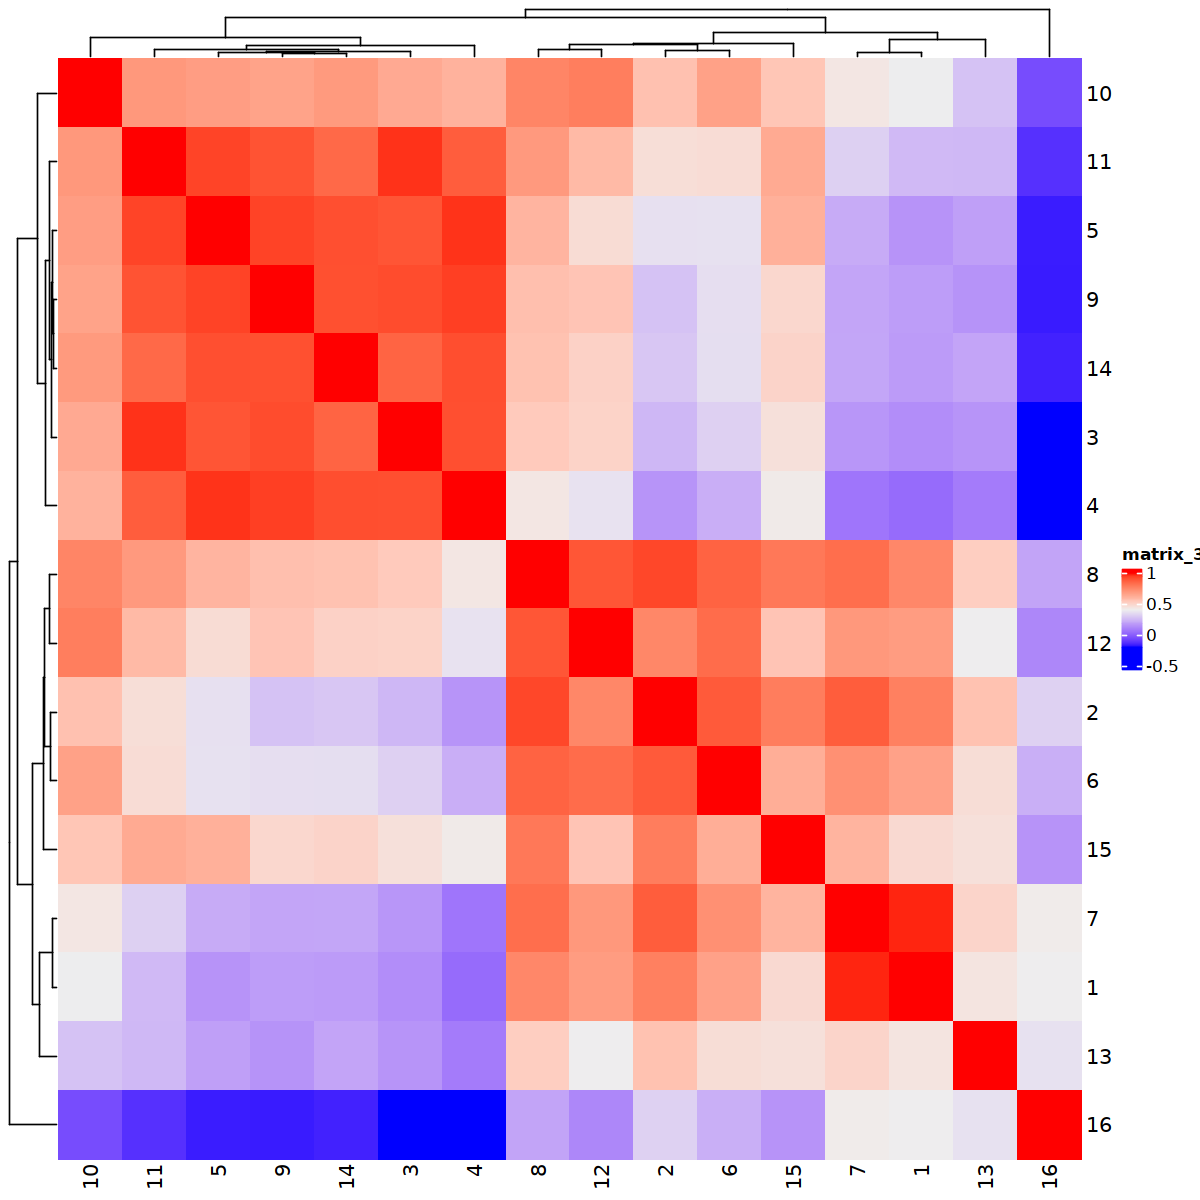

In [109]:
Os.leaf.presto.corr <- marker_correlation(Os.leaf.presto,
           meta_slot = "meta",
           counts_raw = "acr_counts_raw",
           cluster_name = "LouvainClusters")

library(modelr)
combined_louvain_clusters <- as_tibble(Os.leaf.presto.corr$corr_matrix) %>%
    pivot_longer(!geneID, names_to = "cluster_name", values_to = "score")  %>% 
    group_by(geneID)  %>% 
      summarize(mean = mean(score),
            var = var(score))

regression <- loess(var ~ mean, data=combined_louvain_clusters)

combined_louvain_clusters.final <- combined_louvain_clusters %>% 
    add_residuals(regression)  %>% 
    arrange(resid, desc = FALSE)  %>% 
    top_n(500)

options(repr.plot.width=10, repr.plot.height=10)
corr_matrix <- Os.leaf.presto.corr$corr_matrix

viz_matrix <- as_tibble(corr_matrix)  %>% 
    dplyr::filter(geneID %in% combined_louvain_clusters.final$geneID)  %>% 
    dplyr::select(-geneID)

Lc_corr_matrix <- cor(data.matrix(viz_matrix))

suppressPackageStartupMessages(library(ComplexHeatmap))
library(ComplexHeatmap)
Heatmap(Lc_corr_matrix)

In [111]:
head(combined_presto_results)

rank,geneID,chr,start,stop,gene_name,cell_type,LC_value,list_index,marker_type
<int>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
23,LOC_Os06g14780,Chr6,8372334,8376921,Zm00001eb280620_pval_0_epidermis,epidermis,LC_1,1,Hua
53,LOC_Os03g37830,Chr3,20978617,20985759,Zm00001eb048930_pval_0_epidermis,epidermis,LC_1,1,Hua
56,LOC_Os05g38350,Chr5,22481302,22484545,Zm_gpat11__gpat12,"epidermis,provascular_strands,L1_spikelet_pair_meristem,L1_glume_primordia,L1_spikelet_meristem,epidermis,exodermis,endodermis",LC_1,1,Zm
88,LOC_Os05g04830,Chr5,2325837,2328042,Zm00001eb354450_pval_0_epidermis,epidermis,LC_1,1,Hua
123,LOC_Os04g33860,Chr4,20508615,20509616,ACL1,Bulliform,LC_1,1,Os_historical
123,LOC_Os04g33860,Chr4,20508615,20509616,Zm_acl1,bulliform_cell,LC_1,1,Zm


In [136]:
combined_presto_results %>% 
    dplyr::filter(LC_value == "LC_13")

rank,geneID,chr,start,stop,gene_name,cell_type,LC_value,list_index,marker_type
<int>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
4,LOC_Os03g20970,Chr3,11893127,11898228,Zm00001eb015530_pval_0_epidermis,epidermis,LC_13,13,Hua
33,LOC_Os03g06010,Chr3,3003412,3004575,OsEXPA25,DifferentingAtrichoblast,LC_13,13,Os_historical
200,LOC_Os07g41230,Chr7,24699494,24703794,LOC_Os07g41230,Trichoblast,LC_13,13,Os_historical
